MIT License

Copyright (c) 2019 Alexey Pechnikov, https://orcid.org/0000-0001-9626-8615 (ORCID)

Build Super-resolution DEM 0.5m from DEM 1m enhanced by one orthophoto image 0.5m

Source dataset: Elevation1 - Mashhad, Iran

Elevation1 DSM + Pléiades Ortho 0.5m pan-sharpened (Orthoimage included)

https://www.intelligence-airbusds.com/en/9317-sample-imagery-detail?product=18896&keyword=&type=366

In [1]:
from osgeo import gdal
import os
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import cKDTree

import matplotlib.pyplot as plt
%matplotlib inline

### Load DEM

In [2]:
# DEM image
dem = xr.open_rasterio("Mashhad-DEM.sample.tif")[0]
# invert y axis
dem.values = dem.values[::-1]
dem.y.values = dem.y.values[::-1]
del dem.attrs['units']

### Load orthophoto image

In [3]:
# orthophoto image 0.5m for the same area as DEM data above
img = xr.open_rasterio("7289-40126_Mashhad.sample.tif")[0]
# invert y axis
img.values = img.values[::-1]
img.y.values = img.y.values[::-1]

### Regrid DEM 1m on the same grid as orthophoto image 0.5m
This is nearest neighbor interpolation without any data quality enhancement

In [4]:
# define source values
df_dem = dem.to_dataframe(name='dem').dropna().reset_index()
# target grid 
df_grid = img.to_dataframe(name='_').reset_index()[['y','x']]
# nearest neighbor interpolation
tree = cKDTree(list(zip(df_dem.x, df_dem.y)))
distance, indices = tree.query(list(zip(df_grid.x, df_grid.y)), k = 1)
values = df_dem.dem.values[indices]
dem2x = xr.DataArray(values.reshape(img.shape),
                          coords=[img.y,img.x])

### Enhance DEM by orthophoto image
As explained in the article we need to transfer spatial components 0-5m

With pixel size 0.5m the required filter radius is equal to 10 pixels because 10*0.5m = 5m

In [5]:
# low-pass filter
def raster_filter(src, gamma):
    dst = src.copy()
    dst.values = gaussian_filter(dst.values.astype(np.float32),gamma,mode='nearest')
    return dst

# define spectrum components to transfer
radius = 5/img.res[0]

img_lowpass = raster_filter(img, radius)
img_hipass  = img - img_lowpass

dem2x_lowpass = raster_filter(dem2x, radius)
dem2x_hipass  = dem2x - dem2x_lowpass

# caclulate approximate scale factor for short wavelenghs
scale = (img_hipass.max()-img_hipass.min())/(dem2x_hipass.max()-dem2x_hipass.min())
scale

# super-resolution dataset
dem2x_hires = dem2x_lowpass + img_hipass/scale

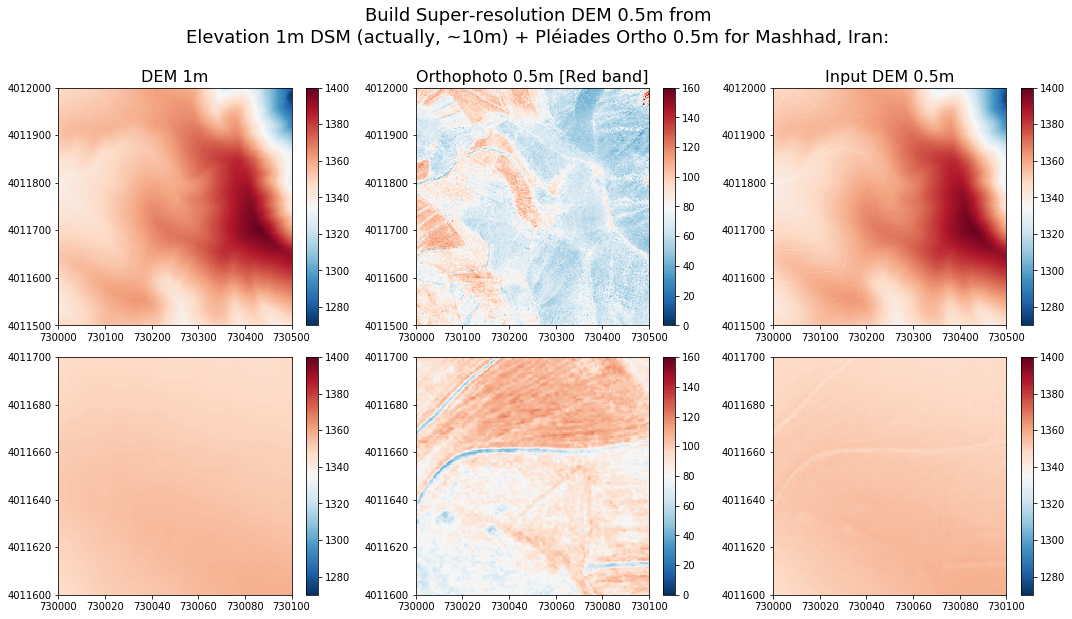

In [6]:
fig, ax = plt.subplots(2,3,figsize=(16,9))
((ax1,ax2,ax3),(ax4,ax5,ax6)) = ax

dem.plot(vmin=1270,vmax=1400,cmap='RdBu_r',ax=ax1)
ax1.set_title('DEM 1m', fontsize=16)
img.plot(vmin=0,vmax=160,cmap='RdBu_r',ax=ax2)
ax2.set_title('Orthophoto 0.5m [Red band]', fontsize=16)

dem.sel(x=slice(730000,730100),y=slice(4011600,4011700)).plot(vmin=1270,vmax=1400,cmap='RdBu_r',ax=ax4)
ax4.set_title('')
img.sel(x=slice(730000,730100),y=slice(4011600,4011700)).plot(vmin=0,vmax=160,cmap='RdBu_r',ax=ax5)
ax5.set_title('')

title = """Build Super-resolution DEM 0.5m from
Elevation 1m DSM (actually, ~10m) + Pléiades Ortho 0.5m for Mashhad, Iran:
"""

dem2x_hires.plot(vmin=1270,vmax=1400,cmap='RdBu_r',ax=ax3)
ax3.set_title('Input DEM 0.5m', fontsize=16)

dem2x_hires.sel(x=slice(730000,730100),y=slice(4011600,4011700)).plot(vmin=1270,vmax=1400,cmap='RdBu_r',ax=ax6)
ax6.set_title('')

for _ax in ax:
    for __ax in _ax:
        __ax.ticklabel_format(useOffset=False)
        __ax.set_xlabel('')
        __ax.set_ylabel('')

plt.suptitle(title, fontsize=18)
fig.tight_layout(rect=[0.03, 0.03, .97, 0.9])
plt.savefig('Super-resolution DEM.jpg', dpi=150)
plt.show()

In [7]:
# compare original and target DEM
float((dem2x_hires-dem2x).mean()),float((dem2x_hires-dem2x).std())

(-0.007677772082388401, 0.4407312572002411)

### Save output

In [8]:
# north semisphere, usually increasing x,y order
def ds2gtif_north(data, filename):
    from osgeo import osr, gdal, ogr

    coordz = list(data.coords)[0]
    coordl = list(data.coords)[1]

    shape = data.shape
    pixelz = round(data[coordz].values[1]-data[coordz].values[0],5)
    pixell = round(data[coordl].values[1]-data[coordl].values[0],5)

    types = ['uint8','uint16','int16','uint32','int32','float32','float64']
    gtypes = [gdal.GDT_Byte, gdal.GDT_UInt16, gdal.GDT_Int16, gdal.GDT_UInt32, gdal.GDT_Int32,
             gdal.GDT_Float32, gdal.GDT_Float64]

    dtype = data.values.dtype
    tidx = types.index(dtype)
    gtype = gtypes[tidx]
    if tidx in [0,1,2,3,4]:
        nodata = np.iinfo(dtype).min
    else:
        nodata = 170141000918780003225695629360656023552.000

    driver = gdal.GetDriverByName("GTiff")
    dst = driver.Create(filename, shape[1], shape[0], 1, gtype, options = [ 'COMPRESS=LZW' ])
    # top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution
    if data[coordz].values[0] < data[coordz].values[-1]:
        zlim = max(data[coordz].values)+pixelz/2
    else:
        zlim = min(data[coordz].values)+pixelz/2

    dst.SetGeoTransform( [ min(data[coordl].values)-pixell/2, pixell, 0, zlim, 0, -pixelz ] )
    if data.epsg is not None:
        srs = osr.SpatialReference()
        #srs.SetWellKnownGeogCS("WGS84")
        srs.ImportFromEPSG(int(data.epsg))
        dst.SetProjection( srs.ExportToWkt() )

    arr = np.flipud(data.values.copy())
    arr[np.isnan(arr)] = nodata

    dst.GetRasterBand(1).SetNoDataValue(nodata)
    dst.GetRasterBand(1).WriteArray(arr)

In [9]:
dem2x_hires.attrs['epsg']=dem.crs.split(':')[1]
ds2gtif_north(dem2x_hires,'dem2x_hires.tif')